In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
def load_and_preprocess_data(filename):
    data = pd.read_csv(filename, index_col=0).transpose()
    data.index = pd.to_datetime(data.index)
    close_prices = data['4. close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices = scaler.fit_transform(close_prices)
    return close_prices, scaler

In [17]:
data, scaler = load_and_preprocess_data('AAPL_stock_data_alpha.csv')

In [18]:
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Activation

def create_alexnet_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=96, kernel_size=11, strides=4, padding='same', activation='relu', input_shape=(input_shape, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=384, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=384, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Prepare model
model = create_alexnet_model(60)  # Assuming look_back=60


C:\Users\jatav\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - loss: 8.5613 - mean_squared_error: 8.5613 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 190ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - loss: 0.0029 - mean_squared_error: 0.

In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(Y_test.reshape(-1, 1))
# Calculate additional performance metrics
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Mean Absolute Error (MAE): 10.803971097570942
R-squared (R²): 0.9816617023747098


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


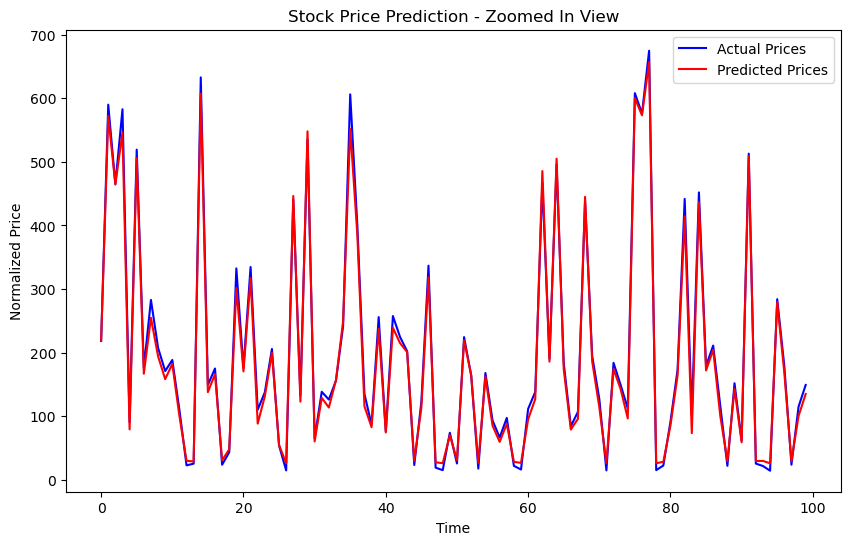

In [22]:
def plot_results(actual, predictions, start=0, end=100):
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end), actual[start:end], label='Actual Prices', color='blue')
    plt.plot(range(start, end), predictions[start:end], label='Predicted Prices', color='red')
    plt.title('Stock Price Prediction - Zoomed In View')
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

# Predict and plot
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Zoom in on the first 100 data points
plot_results(actual.flatten(), predictions.flatten(), start=0, end=100)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 207ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.1077e-04 - val_mean_squared_error: 4.1077e-04
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - loss: 9.2382e-04 - mean_squared_error: 9.2382e-04 - val_loss: 2.4315e-04 - val_mean_squared_error: 2.4315e-04
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - loss: 8.6166e-04 - mean_squared_error: 8.6166e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 2.0729e-04 - val_mean_squared_error: 2.0729e-04
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - loss: 9.8197e-04 - mean_squared_error: 9.8197e-04 - val_loss: 4.2005e-04 - val_mean_squared_error: 4.2005e-04
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


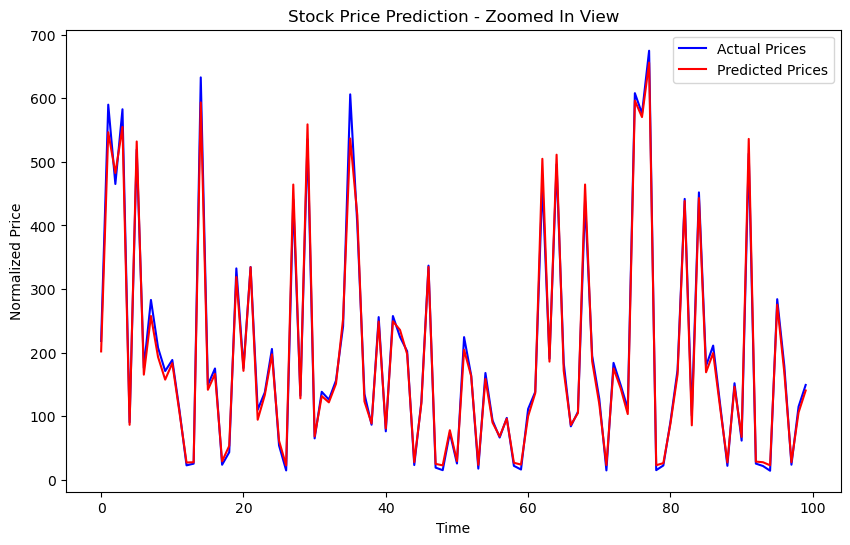

In [25]:
def plot_results(actual, predictions, start=0, end=100):
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end), actual[start:end], label='Actual Prices', color='blue')
    plt.plot(range(start, end), predictions[start:end], label='Predicted Prices', color='red')
    plt.title('Stock Price Prediction - Zoomed In View')
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

# Predict and plot
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Zoom in on the first 100 data points
plot_results(actual.flatten(), predictions.flatten(), start=0, end=100)

In [26]:
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 8.24569718180655
R-squared (R²): 0.9840175624274274
